In [ ]:
# default_exp experiments.utils

In [ ]:
# export
import time
import os
# Limit number of threads in numpy and others to avoid throttling
os.environ["OMP_NUM_THREADS"] = "2" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "2" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "3" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "2" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "3" # export NUMEXPR_NUM_THREADS=6

import numpy as np
import pandas as pd
import argparse
import pickle
import glob
import itertools
import random
from datetime import datetime
from functools import partial

from nixtla.data.scalers import Scaler
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

# Models
from nixtla.models.nbeats.nbeats import Nbeats
from nixtla.models.esrnn.esrnn import ESRNN
from nixtla.models.tcn.tcn import TCN
from nixtla.models.esrnn.rnn import RNN
# import warnings
# warnings.filterwarnings("ignore")

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [ ]:
# export
def get_mask_df(Y_df, timestamps_in_outsample):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(timestamps_in_outsample)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

In [ ]:
#export
def scale_data(Y_df, X_df, mask_df, normalizer_y, normalizer_x):
    y_shift = None
    y_scale = None

    # mask = mask.astype(int)
    mask = mask_df['available_mask'].values * mask_df['sample_mask'].values
    
    if normalizer_y is not None:
        scaler_y = Scaler(normalizer=normalizer_y)
        Y_df['y'] = scaler_y.scale(x=Y_df['y'].values, mask=mask)
    else:
        scaler_y = None

    if normalizer_x is not None:
        X_cols = [col for col in X_df.columns if col not in ['unique_id','ds']]
        for col in X_cols:
            scaler_x = Scaler(normalizer=normalizer_x)
            X_df[col] = scaler_x.scale(x=X_df[col].values, mask=mask)

    return Y_df, X_df, scaler_y

In [ ]:
# export
def train_val_split(len_series, offset, window_sampling_limit, n_val_weeks, ds_per_day):
    last_ds = len_series - offset
    first_ds = max(last_ds - window_sampling_limit, 0)

    last_day = int(last_ds/ds_per_day)
    first_day = int(first_ds/ds_per_day)

    days = set(range(first_day, last_day)) # All days, to later get train days
    # Sample weeks from here, -7 to avoid sampling from last week
    # To not sample first week and have inputs
    sampling_days = set(range(first_day + 7, last_day - 7))
    validation_days = set({}) # Val days set
    
    # For loop for n of weeks in validation
    for i in range(n_val_weeks):
        # Sample random day, init of week
        init_day = random.sample(sampling_days, 1)[0]
        # Select days of sampled init of week
        sampled_days = list(range(init_day, min(init_day+7, last_day)))
        # Add days to validation days
        validation_days.update(sampled_days)
        # Remove days from sampling_days, including overlapping resulting previous week
        days_to_remove = set(range(init_day-6, min(init_day+7, last_day)))
        sampling_days = sampling_days.difference(days_to_remove)

    train_days = days.difference(validation_days)

    train_days = sorted(list(train_days))
    validation_days = sorted(list(validation_days))

    train_idx = []
    for day in train_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        train_idx += hours_idx

    val_idx = []
    for day in validation_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        val_idx += hours_idx

    assert all([idx < last_ds for idx in val_idx]), 'Leakage!!!!'
    
    return train_idx, val_idx

In [ ]:
# export
def create_datasets(mc, Y_df, X_df, S_df, timestamps_in_outsample, shuffle_outsample, offset):
    #TODO: offset not implemented
    #TODO: shuffle_outsample

    # n_timestamps_pred defines number of hours ahead to predict
    # offset defines the shift of the data to simulate rolling window
    # assert offset % n_timestamps_pred == 0, 'Avoid overlap of predictions, redefine n_timestamps_pred or offset' <-- restriccion poco general

    #------------------------------------- Available and Validation Mask ------------------------------------#
    # mask: 1 last_n_timestamps, 0 timestamps until last_n_timestamps
    train_mask_df = get_mask_df(Y_df=Y_df, timestamps_in_outsample=timestamps_in_outsample)
    outsample_mask_df = train_mask_df.copy()

    # Difference in mask, esrnn and rnn needs fulls time series even in outsample due to hidden state
    if mc['model'] in ['nbeats', 'tcn']:
        outsample_mask_df['sample_mask'] = 1 - outsample_mask_df['sample_mask']
    elif mc['model'] in ['esrnn', 'rnn']:
        outsample_mask_df['sample_mask'] = 1

    #---------------------------------------------- Scale Data ----------------------------------------------#
    # Scale data # TODO: write sample_mask conditional/groupby(['unique_id]) scaling
    Y_df, X_df, scaler_y = scale_data(Y_df=Y_df, X_df=X_df, mask_df=train_mask_df,
                                      normalizer_y=mc['normalizer_y'], normalizer_x=mc['normalizer_x'])

    #----------------------------------------- Declare Dataset and Loaders ----------------------------------#
    train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=train_mask_df)
    if timestamps_in_outsample == 0:
        outsample_ts_dataset = None
    else:
        outsample_ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=outsample_mask_df)

    return train_ts_dataset, outsample_ts_dataset, scaler_y

In [ ]:
# export
def instantiate_loaders(mc, train_ts_dataset, outsample_ts_dataset):
    train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                       model=mc['model'],
                                       offset=0,
                                       window_sampling_limit=int(mc['window_sampling_limit']),
                                       input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                       output_size=int(mc['output_size']),
                                       idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                       batch_size=int(mc['batch_size']),
                                       complete_inputs=mc['complete_inputs'],
                                       n_series_per_batch=mc['n_series_per_batch'],
                                       complete_sample=mc['complete_sample'],
                                       shuffle=True)

    if outsample_ts_dataset is not None:
        val_ts_loader = TimeSeriesLoader(ts_dataset=outsample_ts_dataset,
                                        model=mc['model'],
                                        offset=0,
                                        window_sampling_limit=int(mc['window_sampling_limit']),
                                        input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                        output_size=int(mc['output_size']),
                                        idx_to_sample_freq=mc['val_idx_to_sample_freq'],
                                        batch_size=int(mc['batch_size']),
                                        complete_inputs=mc['complete_inputs'],
                                        n_series_per_batch=mc['n_series_per_batch'],
                                        complete_sample=mc['complete_sample'],
                                        shuffle=False)
    else:
        val_ts_loader = None

    return train_ts_loader, val_ts_loader

In [ ]:
# export
def instantiate_nbeats(mc):
    mc['n_hidden_list'] = len(mc['stack_types']) * [ mc['n_layers'][0]*[mc['n_hidden']] ]
    model = Nbeats(input_size_multiplier=mc['input_size_multiplier'],
                   output_size=int(mc['output_size']),
                   shared_weights=mc['shared_weights'],
                   initialization=mc['initialization'],
                   activation=mc['activation'],
                   stack_types=mc['stack_types'],
                   n_blocks=mc['n_blocks'],
                   n_layers=mc['n_layers'],
                   n_hidden=mc['n_hidden_list'],
                   n_harmonics=int(mc['n_harmonics']),
                   n_polynomials=int(mc['n_polynomials']),
                   x_s_n_hidden=int(mc['x_s_n_hidden']),
                   exogenous_n_channels=int(mc['exogenous_n_channels']),
                   batch_normalization = mc['batch_normalization'],
                   dropout_prob_theta=mc['dropout_prob_theta'],
                   dropout_prob_exogenous=mc['dropout_prob_exogenous'],
                   learning_rate=float(mc['learning_rate']),
                   lr_decay=float(mc['lr_decay']),
                   n_lr_decay_steps=float(mc['n_lr_decay_steps']),
                   weight_decay=mc['weight_decay'],
                   l1_theta=mc['l1_theta'],
                   n_iterations=int(mc['n_iterations']),
                   early_stopping=int(mc['early_stopping']),
                   loss=mc['loss'],
                   loss_hypar=float(mc['loss_hypar']),
                   val_loss=mc['val_loss'],
                   frequency=mc['frequency'],
                   seasonality=int(mc['seasonality']),
                   random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_esrnn(mc):    
    model = ESRNN(input_size=int(mc['input_size_multiplier']*mc['output_size']),
                  output_size=int(mc['output_size']),
                  max_epochs=int(mc['max_epochs']),
                  learning_rate=mc['learning_rate'],
                  lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                  lr_decay=mc['lr_decay'],
                  per_series_lr_multip=mc['per_series_lr_multip'],
                  gradient_eps=mc['gradient_eps'],
                  gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                  rnn_weight_decay=mc['rnn_weight_decay'],
                  noise_std=mc['noise_std'],
                  level_variability_penalty=mc['level_variability_penalty'],
                  testing_percentile=mc['testing_percentile'],
                  training_percentile=mc['training_percentile'],
                  es_component=mc['es_component'],
                  cell_type=mc['cell_type'],
                  state_hsize=int(mc['state_hsize']),
                  dilations=mc['dilations'],
                  add_nl_layer=mc['add_nl_layer'],
                  loss=mc['loss'],
                  seasonality=mc['seasonality'],
                  random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_rnn(mc):
    model = RNN(input_size=int(mc['input_size_multiplier']*mc['output_size']),
                output_size=int(mc['output_size']),
                max_epochs=int(mc['max_epochs']),
                learning_rate=mc['learning_rate'],
                lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                lr_decay=mc['lr_decay'],
                gradient_eps=mc['gradient_eps'],
                gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                rnn_weight_decay=mc['rnn_weight_decay'],
                noise_std=mc['noise_std'],
                testing_percentile=mc['testing_percentile'],
                training_percentile=mc['training_percentile'],
                cell_type=mc['cell_type'],
                state_hsize=int(mc['state_hsize']),
                dilations=mc['dilations'],
                add_nl_layer=mc['add_nl_layer'],
                loss=mc['loss'],
                random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_tcn(mc):
    model = TCN(output_size=int(mc['output_size']),
                n_channels=mc['n_channels'],
                kernel_size=int(mc['kernel_size']),
                initialization=mc['initialization'],
                learning_rate=mc['learning_rate'],
                lr_decay=mc['lr_decay'],
                n_lr_decay_steps=mc['n_lr_decay_steps'],
                weight_decay=mc['weight_decay'],
                dropout_prob=mc['dropout_prob'],
                n_iterations=int(mc['n_iterations']),
                early_stopping=int(mc['early_stopping']),
                loss=mc['loss'],
                val_loss=mc['val_loss'],
                frequency=mc['frequency'],
                random_seed=int(mc['random_seed']),
                seasonality=mc['seasonality'])
    return model

In [ ]:
# export
def instantiate_model(mc):
    MODEL_DICT = {'nbeats': instantiate_nbeats,
                  'esrnn': instantiate_esrnn,
                  'rnn': instantiate_rnn,
                  'tcn': instantiate_tcn}
    return MODEL_DICT[mc['model']](mc)

In [ ]:
# export
def model_fit_predict(mc, Y_df, X_df, S_df, timestamps_in_outsample, expected_fcds, shuffle_outsample):
    #TODO: rolling forecast
    #TODO: expected_fcds
    
    Y_df = Y_df.copy()
    if X_df is not None:
        X_df = X_df.copy()
    if S_df is not None:
        S_df = S_df.copy()

    #----------------------------------------------- Datasets -----------------------------------------------#
    train_ts_dataset, outsample_ts_dataset, scaler_y = create_datasets(mc=mc, Y_df=Y_df, X_df=X_df,
                                                                       S_df=S_df,
                                                                       timestamps_in_outsample=timestamps_in_outsample,
                                                                       shuffle_outsample=shuffle_outsample,
                                                                       offset=0)

    #--------------------------------------- Instantiate, fit, predict ---------------------------------------#
    train_ts_loader, val_ts_loader = instantiate_loaders(mc=mc, train_ts_dataset=train_ts_dataset,
                                                         outsample_ts_dataset=outsample_ts_dataset)
    model = instantiate_model(mc=mc)

    # Val loader not implemented during training for ESRNN and RNN
    if mc['model'] in ['nbeats', 'tcn']:
        model.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, verbose=True,
                    eval_freq=mc['eval_freq'])
        y_true, y_hat, mask = model.predict(ts_loader=val_ts_loader, eval_mode=True)

    elif mc['model'] in ['esrnn', 'rnn']:
        model.fit(train_ts_loader=train_ts_loader, verbose=True, eval_freq=mc['eval_freq'])
        y_true, y_hat, mask = model.predict(ts_loader=val_ts_loader, n_fcds=expected_fcds, eval_mode=True)

    print("y_true.shape (#n_series, #n_fcds, #lt) ", y_true.shape)
    print("y_hat.shape (#n_series, #n_fcds, #lt) ", y_hat.shape)
    print("\n")

    assert y_true.shape[1] == expected_fcds, 'Error in fcds per serie.'
    assert y_hat.shape[1] == expected_fcds, 'Error in fcds per serie.'
    
    meta_data = val_ts_loader.ts_dataset.meta_data

    return y_true, y_hat, mask, meta_data, model

In [ ]:
# export
def evaluate_model(mc, loss_function, Y_df, X_df, S_df, timestamps_in_outsample, expected_fcds, shuffle_outsample):
    
    # Some asserts due to work in progress
    assert mc['normalizer_y'] is None, 'Scaling Y not iplemented (inverse Y missing for loss)'

    n_series = Y_df['unique_id'].nunique()
    if n_series > 1:
        assert mc['normalizer_x'] is None, 'Data scaling not implemented with multiple time series'
    assert shuffle_outsample == False, 'Shuffle outsample not implemented'

    assert timestamps_in_outsample % mc['val_idx_to_sample_freq']==0, 'outsample size should be multiple of val_idx_to_sample_freq'

    # Make predictions
    start = time.time()
    y_true, y_hat, mask, meta_data, model = model_fit_predict(mc, Y_df, X_df, S_df, timestamps_in_outsample,
                                                              expected_fcds, shuffle_outsample)
    run_time = time.time() - start

    # Evaluate predictions
    loss = loss_function(y=y_true, y_hat=y_hat, weights=mask)

    result =  {'loss': loss,
               'mc': mc,
               'y_true': y_true,
               'y_hat': y_hat,
               'trajectories': model.trajectories,
               'run_time': run_time,
               'status': STATUS_OK}
    return result

In [ ]:
# export
def hyperopt_tunning(space, hyperopt_iters, loss_function, Y_df, X_df, S_df, timestamps_in_outsample, expected_fcds,
                     shuffle_outsample, save_trials=False):
    trials = Trials()
    fmin_objective = partial(evaluate_model, loss_function=loss_function, Y_df=Y_df, X_df=X_df, S_df=S_df,
                             timestamps_in_outsample=timestamps_in_outsample,
                             expected_fcds=expected_fcds,
                             shuffle_outsample=shuffle_outsample)

    fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=hyperopt_iters, trials=trials, verbose=True)

    return trials

# TESTS

In [ ]:
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

In [ ]:
space= {# Architecture parameters
        'model':'nbeats',
        'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
        'output_size': hp.choice('output_size', [24]),
        'shared_weights': hp.choice('shared_weights', [False]),
        'activation': hp.choice('activation', ['selu']),
        'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
        'stack_types': hp.choice('stack_types', [2*['identity'],
                                                    1*['identity']+1*['exogenous_tcn'],
                                                    1*['exogenous_tcn']+1*['identity'] ]),
        'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
        'n_layers': hp.choice('n_layers', [ [2, 2] ]),
        'n_hidden': hp.choice('n_hidden', [ 364 ]),
        'n_harmonics': hp.choice('n_harmonics', [1]),
        'n_polynomials': hp.choice('n_polynomials', [2]),
        'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
        'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
        # Regularization and optimization parameters
        'batch_normalization': hp.choice('batch_normalization', [False]),
        'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
        'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
        'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
        'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
        'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
        'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
        'n_iterations': hp.choice('n_iterations', [100]), #[args.max_epochs]),
        'early_stopping': hp.choice('early_stopping', [16]),
        'eval_freq': hp.choice('eval_freq', [50]),
        'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
        'loss': hp.choice('loss', ['MAE']),
        'loss_hypar': hp.choice('loss_hypar', [0.5]),                
        'val_loss': hp.choice('val_loss', ['MAE']), #[args.val_loss]),
        'l1_theta': hp.choice('l1_theta', [0]),
        # Data parameters
        'normalizer_y': hp.choice('normalizer_y', [None]),
        'normalizer_x': hp.choice('normalizer_x', ['median']),
        'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
        'complete_inputs': hp.choice('complete_inputs', [False]),
        'complete_sample': hp.choice('complete_sample', [False]),                
        'frequency': hp.choice('frequency', ['H']),
        'seasonality': hp.choice('seasonality', [24]),      
        'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
        'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
        'batch_size': hp.choice('batch_size', [256]),
        'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
        'random_seed': hp.quniform('random_seed', 10, 20, 1)}

In [ ]:
mc = {'model':'nbeats',
      # Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'shared_weights': False,
      'activation': 'selu',
      'initialization': 'he_normal',
      'stack_types': ['exogenous_tcn']+1*['identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_hidden': 364,
      'n_polynomials': 2,
      'n_harmonics': 1,
      'exogenous_n_channels': 3,
      'x_s_n_hidden': 0,
      # Regularization and optimization parameters
      'batch_normalization': False,
      'dropout_prob_theta': 0.2,
      'dropout_prob_exogenous': 0.2,
      'learning_rate': 0.0005, #0.002,
      'lr_decay': 0.64,
      'n_lr_decay_steps': 3,
      'weight_decay': 0.00015,
      'n_iterations': 100,
      'early_stopping': 8,
      'eval_freq': 50,
      'n_val_weeks': 52*2,
      'loss': 'PINBALL',
      'loss_hypar': 0.5, #0.49,
      'val_loss': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'window_sampling_limit': 100_000,
      'complete_inputs': False,
      'complete_sample': False,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'batch_size': 256,
      'n_series_per_batch': 1,
      'random_seed': 10}

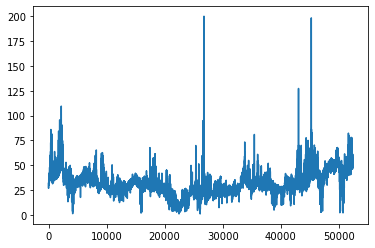

In [ ]:
from nixtla.data.datasets.epf import EPF, EPFInfo
import matplotlib.pyplot as plt

dataset = ['NP']

Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=dataset)

plt.plot(Y_df.y.values)
plt.show()

In [ ]:
result = evaluate_model(loss_function=mae, mc=mc, Y_df=Y_df, X_df=X_df, S_df=S_df, timestamps_in_outsample=7*24,
                        expected_fcds=7, shuffle_outsample=False)
result



============================== Start fitting ==============================
Step: 50, Time: 5.976, Insample PINBALL: 1.12246, Outsample MAE: 2.68037
Step: 100, Time: 12.024, Insample PINBALL: 0.90097, Outsample MAE: 2.47039
Step: 100, Time: 12.038, Insample PINBALL: 0.90097, Outsample MAE: 2.47039
==============================  End fitting  ==============================


y_true.shape (#n_series, #n_fcds, #lt)  (1, 7, 24)
y_hat.shape (#n_series, #n_fcds, #lt)  (1, 7, 24)




{'loss': 2.4703877,
 'mc': {'model': 'nbeats',
  'input_size_multiplier': 7,
  'output_size': 24,
  'shared_weights': False,
  'activation': 'selu',
  'initialization': 'he_normal',
  'stack_types': ['exogenous_tcn', 'identity'],
  'n_blocks': [1, 1],
  'n_layers': [2, 2],
  'n_hidden': 364,
  'n_polynomials': 2,
  'n_harmonics': 1,
  'exogenous_n_channels': 3,
  'x_s_n_hidden': 0,
  'batch_normalization': False,
  'dropout_prob_theta': 0.2,
  'dropout_prob_exogenous': 0.2,
  'learning_rate': 0.0005,
  'lr_decay': 0.64,
  'n_lr_decay_steps': 3,
  'weight_decay': 0.00015,
  'n_iterations': 100,
  'early_stopping': 8,
  'eval_freq': 50,
  'n_val_weeks': 104,
  'loss': 'PINBALL',
  'loss_hypar': 0.5,
  'val_loss': 'MAE',
  'l1_theta': 0,
  'normalizer_y': None,
  'normalizer_x': 'median',
  'window_sampling_limit': 100000,
  'complete_inputs': False,
  'complete_sample': False,
  'frequency': 'H',
  'seasonality': 24,
  'idx_to_sample_freq': 24,
  'val_idx_to_sample_freq': 24,
  'batch_si

In [ ]:
trials = hyperopt_tunning(space=space, hyperopt_iters=3, loss_function=mae, Y_df=Y_df, X_df=X_df, S_df=S_df,
                          timestamps_in_outsample=728*24, expected_fcds=728, shuffle_outsample=False)

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.013141 seconds
INFO:hyperopt.tpe:TPE using 0 trials
============================== Start fitting ==============================
Step: 50, Time: 5.960, Insample MAE: 2.00787, Outsample MAE: 2.31702
Step: 100, Time: 11.968, Insample MAE: 1.64655, Outsample MAE: 2.21039
Step: 100, Time: 12.076, Insample MAE: 1.64655, Outsample MAE: 2.21039
==============================  End fitting  ==============================
y_true.shape (#n_series, #n_fcds, #lt) 
(1, 728, 24)
y_hat.shape (#n_series, #n_fcds, #lt) 
(1, 728, 24)
 33%|███▎      | 1/3 [00:12<00:24, 12.45s/trial, best loss: 2.2103867530822754]INFO:hyperopt.tpe:build_posterior_wrapper took 0.012028 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.210387
============================== Start fitting ==============================
Step: 50, Time: 5.881, Insample MAE: 1.95946, Outsample MAE: 2.35648
Step: 100, Time: 12.187, In

In [ ]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 2.2103867530822754,
   'mc': {'activation': 'selu',
    'batch_normalization': False,
    'batch_size': 256,
    'complete_inputs': False,
    'complete_sample': False,
    'dropout_prob_exogenous': 0.04749751561173515,
    'dropout_prob_theta': 0.3467697435492925,
    'early_stopping': 16,
    'eval_freq': 50,
    'exogenous_n_channels': 3.0,
    'frequency': 'H',
    'idx_to_sample_freq': 24,
    'initialization': 'glorot_normal',
    'input_size_multiplier': 7,
    'l1_theta': 0,
    'learning_rate': 0.000752546395212654,
    'loss': 'MAE',
    'loss_hypar': 0.5,
    'lr_decay': 0.42259833155713494,
    'model': 'nbeats',
    'n_blocks': (1, 1),
    'n_harmonics': 1,
    'n_hidden': 364,
    'n_iterations': 100,
    'n_layers': (2, 2),
    'n_lr_decay_steps': 3,
    'n_polynomials': 2,
    'n_series_per_batch': 1,
    'n_val_weeks': 104,
    'normalizer_x': 'median',
    'normalizer_y': None,
    'output_size': 24,
    '